<a href="https://colab.research.google.com/github/harvard-ml-courses/a-cs281-demo/blob/master/15_UGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 15 - Unidirected Graphical Models

In [0]:
!pip install -qU plotly torch daft opt-einsum networkx
!rm -fr start; git clone --single-branch -b demos2018 -q https://github.com/harvard-ml-courses/cs281-demos start; cp -f start/cs281.py cs281.py

tcmalloc: large alloc 1073750016 bytes == 0x59d7c000 @  0x7fadeae272a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
G = nx.Graph()

ModuleNotFoundError: ignored

In [0]:
# Matrix sum trick 
# Einstein Summation. 
x = torch.ones(5)
y = torch.ones(4)
print(x)
print(y)
print(torch.einsum("a,b->b", [x, y]))
print(torch.einsum("a,b->a", [x, y]))

tensor([1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1.])
tensor([5., 5., 5., 5.])
tensor([4., 4., 4., 4., 4.])


In [0]:
psi = {}
sizes = {"a": 10, 
         "b": 5, 
         "c": 20,
         "d": 30,
         "e": 40}

In [0]:
# Unary potentials
G.add_node("a")
psi["a"] = torch.rand(sizes["a"])

G.add_node("b")
psi["b"] = torch.rand(sizes["b"])


G.add_node("c")
psi["c"] = torch.rand(sizes["c"])

G.add_node("d")
psi["d"] = torch.rand(sizes["d"])


G.add_node("e")
psi["e"] = torch.rand(sizes["e"])


In [0]:
# Clique potentials
G.add_edge("a", "b")
G.add_edge("a", "c")
G.add_edge("c", "b")
psi["abc"] = torch.rand(sizes["a"], sizes["b"], sizes["c"])


G.add_edge("c", "d")
psi["cd"] = torch.rand(sizes["c"], sizes["d"])


G.add_edge("c", "e")
psi["ce"] = torch.rand(sizes["c"], sizes["e"])


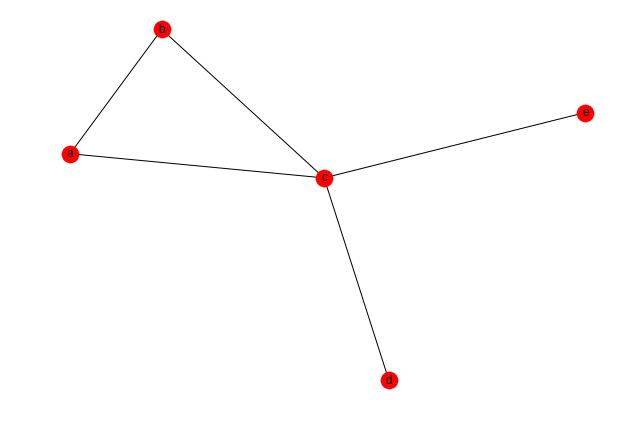

In [0]:
nx.draw(G, with_labels=True)

In [0]:
torch.einsum("a,b,c,d,e,abc,cd,ce->a", 
             [psi["a"], psi["b"], psi["c"], psi["d"], psi["e"], psi["abc"], psi["cd"], psi["ce"]])

tensor([113.5827, 129.6138, 171.6176, 563.8849, 748.7998, 581.9191, 949.3260,
        899.4585, 214.6330, 824.9941])

(See amazing einsum tutorial https://rockt.github.io/2018/04/30/einsum )

In [0]:
# Cutesy implementation
torch.einsum(",".join(psi.keys()) + "->a", 
             list(psi.values()))

tensor([113.5827, 129.6138, 171.6176, 563.8849, 748.7998, 581.9191, 949.3260,
        899.4585, 214.6330, 824.9941])

In [0]:
# What is really happening?
# Brute-Force
total = 0
for a in range(sizes["a"]):
    for b in range(sizes["b"]):
        for c in range(sizes["c"]):
            for d in range(sizes["d"]):
                for e in range(sizes["e"]):
                    total += psi["a"][a] * psi["b"][b] * psi["c"][c] * psi["d"][d] * psi["e"][e] * psi["abc"][a,b,c] * psi["cd"][c, d] * psi["ce"][c, e]

In [0]:
total

tensor(5191.4873)

In [0]:
# Dynamic programming
table = {}
total = {}
for c in range(sizes["c"]):
    ds = 0
    es = 0
    for d in range(sizes["d"]):
        ds += psi["d"][d] * psi["cd"][c, d]
    for e in range(sizes["e"]):
        es += psi["e"][e] * psi["ce"][c, e]
    table[c] = ds * es
    print(ds)

for a in range(sizes["a"]):
    total[a] = 0
    for b in range(sizes["b"]):
        for c in range(sizes["c"]):
            total[a] += psi["a"][a] * psi["b"][b] * psi["abc"][a,b,c] * psi["c"][c] * table[c]                  
total

tensor(6.2404)
tensor(6.7964)
tensor(6.9120)
tensor(4.6440)
tensor(6.8203)
tensor(5.1265)
tensor(7.0055)
tensor(9.1019)
tensor(7.0359)
tensor(5.6653)
tensor(5.8504)
tensor(6.6202)
tensor(6.0950)
tensor(5.8959)
tensor(6.2333)
tensor(8.9158)
tensor(6.2573)
tensor(7.0358)
tensor(6.9736)
tensor(5.7229)


{0: tensor(113.5827),
 1: tensor(129.6138),
 2: tensor(171.6176),
 3: tensor(563.8849),
 4: tensor(748.7997),
 5: tensor(581.9191),
 6: tensor(949.3261),
 7: tensor(899.4587),
 8: tensor(214.6330),
 9: tensor(824.9941)}

In [0]:
import opt_einsum as oe

In [0]:
print(oe.contract_path("a,b,c,d,e,abc,cd,ce->a", 
                 psi["a"], psi["b"], psi["c"], psi["d"], psi["e"], psi["abc"], psi["cd"], psi["ce"])[1])

  Complete contraction:  a,b,c,d,e,abc,cd,ce->a
         Naive scaling:  5
     Optimized scaling:  3
      Naive FLOP count:  9.600e+06
  Optimized FLOP count:  5.250e+03
   Theoretical speedup:  1828.571
  Largest intermediate:  2.000e+02 elements
--------------------------------------------------------------------------------
scaling        BLAS                current                             remaining
--------------------------------------------------------------------------------
   2           GEMM                ce,e->c                   a,b,c,d,abc,cd,c->a
   3    GEMV/EINSUM              abc,b->ac                      a,c,d,cd,c,ac->a
   2           GEMM                cd,d->c                         a,c,c,ac,c->a
   1          False                 c,c->c                           a,ac,c,c->a
   1          False                 c,c->c                             a,ac,c->a
   2           GEMM                c,ac->a                                a,a->a
   1          False  